In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(5678)

In [2]:
def _make_circular_data(num_sectors):
    """Generate datapoints arranged in an even circle."""
    center_indices = np.arange(num_sectors)
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + 0.5) * sector_angle
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    labels = 2 * np.remainder(np.floor_divide(angles, sector_angle), 2) - 1

    return x, y, labels

def make_double_cake_data(num_sectors):
    x1, y1, labels1 = _make_circular_data(num_sectors)
    x2, y2, labels2 = _make_circular_data(num_sectors)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y

# Example usage:
# num_sectors = 8
# X, Y = make_double_cake_data(num_sectors)
# print(X)
# print(Y)

In [3]:
import numpy as np

def _make_circular_data(num_sectors):
    """
    Generate datapoints arranged in an even circle.
    
    Parameters:
    num_sectors (int): Number of sectors to divide the circle into.
    
    Returns:
    tuple: Arrays of x coordinates, y coordinates, and labels.
    """
    # Calculate the angles for each sector
    center_indices = np.arange(num_sectors)
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + 0.5) * sector_angle
    
    # Calculate x and y coordinates
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    
    # Generate labels for the sectors
    labels = 2 * (np.floor_divide(center_indices, 2) % 2) - 1

    return x, y, labels

def make_double_cake_data(num_sectors):
    """
    Generate double cake data points.
    
    Parameters:
    num_sectors (int): Number of sectors to divide the circle into.
    
    Returns:
    tuple: Arrays of coordinates and corresponding labels.
    """
    # Create two sets of circular data
    x1, y1, labels1 = _make_circular_data(num_sectors)
    x2, y2, labels2 = _make_circular_data(num_sectors)
    
    # Combine x and y coordinates of the two sets, scaling the second set by 0.5
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])
    
    # Combine the coordinates into a single array
    X = np.vstack([x, y]).T
    
    # Combine labels and negate the labels of the second set
    labels = np.hstack([labels1, -labels2])
    
    # Convert labels to integer type
    Y = labels.astype(int)

    return X, Y

# Example usage:
# num_sectors = 8
# X, Y = make_double_cake_data(num_sectors)
# print(X)
# print(Y)


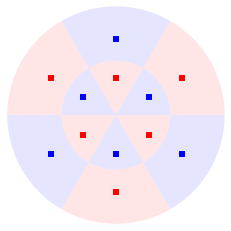

In [5]:
import matplotlib.pyplot as plt

num_sectors = 6
X, Y = make_double_cake_data(num_sectors)

ax = plot_double_cake_data(X, Y, plt.gca(), num_sectors=num_sectors)

In [6]:
import pennylane as qml


def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

In [7]:
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

In [8]:
dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

In [9]:
@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

In [10]:
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

In [11]:
init_params = random_params(num_wires=5, num_layers=6)

In [12]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.260


In [13]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(X, init_kernel, assume_normalized_kernel=True)

with np.printoptions(precision=3, suppress=True):
    print(K_init)

[[1.    0.26  0.025 0.055 0.001 0.071 0.574 0.335 0.069 0.014 0.    0.093]
 [0.26  1.    0.231 0.023 0.004 0.021 0.246 0.545 0.192 0.024 0.019 0.052]
 [0.025 0.231 1.    0.197 0.012 0.006 0.062 0.339 0.664 0.305 0.072 0.017]
 [0.055 0.023 0.197 1.    0.167 0.048 0.024 0.023 0.222 0.576 0.211 0.051]
 [0.001 0.004 0.012 0.167 1.    0.251 0.026 0.033 0.083 0.288 0.638 0.255]
 [0.071 0.021 0.006 0.048 0.251 1.    0.222 0.071 0.045 0.102 0.347 0.679]
 [0.574 0.246 0.062 0.024 0.026 0.222 1.    0.701 0.294 0.109 0.149 0.534]
 [0.335 0.545 0.339 0.023 0.033 0.071 0.701 1.    0.616 0.184 0.142 0.256]
 [0.069 0.192 0.664 0.222 0.083 0.045 0.294 0.616 1.    0.63  0.296 0.195]
 [0.014 0.024 0.305 0.576 0.288 0.102 0.109 0.184 0.63  1.    0.651 0.266]
 [0.    0.019 0.072 0.211 0.638 0.347 0.149 0.142 0.296 0.651 1.    0.613]
 [0.093 0.052 0.017 0.051 0.255 0.679 0.534 0.256 0.195 0.266 0.613 1.   ]]


In [14]:
from sklearn.svm import SVC

In [15]:
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X, Y)

In [16]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


accuracy_init = accuracy(svm, X, Y)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")

The accuracy of the kernel with random parameters is 0.583


In [17]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data

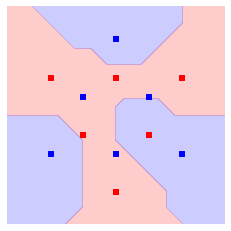

In [18]:
init_plot_data = plot_decision_boundaries(svm, plt.gca())

In [19]:
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.035


In [20]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


params = init_params
opt = qml.GradientDescentOptimizer(0.2)

for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        X[subset],
        Y[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

Step 50 - Alignment = 0.041
Step 100 - Alignment = 0.046
Step 150 - Alignment = 0.050
Step 200 - Alignment = 0.055
Step 250 - Alignment = 0.059
Step 300 - Alignment = 0.064
Step 350 - Alignment = 0.069
Step 400 - Alignment = 0.072
Step 450 - Alignment = 0.078
Step 500 - Alignment = 0.086


In [21]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)

In [22]:
accuracy_trained = accuracy(svm_trained, X, Y)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 0.833


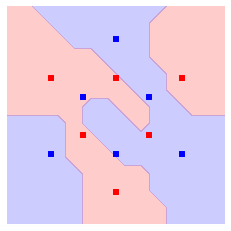

In [23]:
trained_plot_data = plot_decision_boundaries(svm_trained, plt.gca())

We finally increased the accuracy on classifying data instances from 0.58 to 0.83.